9. Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [0]:
import os

import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
# Save
def show_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis('off')

In [3]:
mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

4423680/4422102 [==============================] - 0s 0us/step


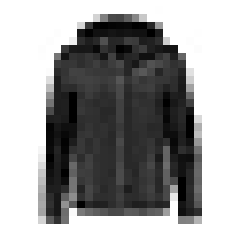

In [4]:
show_image(X_train[0])

In [0]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [0]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

In [0]:
def create_example(image, label):
    data = tf.io.serialize_tensor(image)
    return Example(
      features=Features(
          feature={
              "image": Feature(bytes_list=BytesList(value=[data.numpy()])),
              "label": Feature(int64_list=Int64List(value=[label]))
          }
      )
  )


In [0]:
from contextlib import ExitStack

def split_data_to_tfrecord(dataset, base_name, num_files=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(base_name, index, num_files)
             for index in range(num_files)]

    with ExitStack() as stack:
      writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
      for i, (X, y) in dataset.enumerate():
        file_no = i % num_files
        example = create_example(X, y)
        writers[file_no].write(example.SerializeToString())

In [0]:
split_data_to_tfrecord(train_set, "train_set")

In [0]:
split_data_to_tfrecord(valid_set, "valid_set")

In [0]:
split_data_to_tfrecord(test_set, "test_set")

In [0]:
feature_description = {
    "image": tf.io.VarLenFeature(tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

In [0]:
dataset = tf.data.TFRecordDataset(["train_set_1.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples, feature_description)

In [0]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f74506694a8>,
 'label': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 3, 8, 7, 6, 1, 1, 0, 5])>}

In [0]:
decoded_img = tf.io.parse_tensor(parsed_examples["image"].values[0], out_type=tf.double)

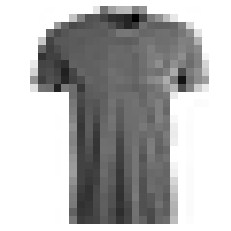

In [0]:
show_image(decoded_img)